# Newton's Method Implementation in PySpark
* Author: Wenhan Wang ([wenhwang@bu.edu](mailto:wenhwang@bu.edu) | [wenhan.wang97@gmail.com](mailto:wenhan.wang97@gmail.com))<br>
* Latest update: 06/23/2022

In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

from pyspark import SparkContext
from pyspark.sql import SparkSession

from sklearn.datasets import make_blobs

In [2]:
sc = SparkContext('local')

In [3]:
sample_size = 100000
dimensions = 2

In [4]:
X_arr, y_arr = make_blobs(n_samples=sample_size,
                          centers=2,
                          n_features=dimensions,
                          cluster_std = [0.5] * 2,
                          random_state=14)

X, y = np.mat(X_arr), np.mat(y_arr).reshape(sample_size, 1)

In [5]:
fig = px.scatter_3d(x=X_arr[:,0], y=X_arr[:,1], z=y_arr, color=np.where(y_arr == 1, 'red', 'blue'))
fig.show()

In [6]:
rdd_X = sc.parallelize(X_arr)
rdd_y = sc.parallelize(y_arr)
data = rdd_y.zip(rdd_X)

In [7]:
data = data.map(lambda x: (x[0],np.append(x[1],1)))
data.cache()

PythonRDD[3] at RDD at PythonRDD.scala:53

Generally, the logistic regression model can be represented by the following equation:<br><br>
$$\log{\frac{p(x)}{1 - p{x}}=\beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \cdots}$$
The $p$ in the equation is the sigmoid equation. Below we have the full equation and a simplified version:<br><br>
$$p(x)=\frac{e^{\beta_0 + \beta_1x_1 + \cdots}}{1 + e^{\beta_0 + \beta_1x_1 + \cdots}}=\frac{1}{1+e^{-(\beta_0 + \beta_1x_1 + \cdots)}}$$
Since we may deal with multi-dimensional data, the sigmoid equation will be written as:<br><br>
$$p(x)=\frac{1}{1+e^{-\beta^Tx}}$$

In [8]:
def sigmoid(theta):
    return 1.0 / (1.0 + np.exp(-theta))

In gradient descent, we will start with an initial model with $\beta_0$ as our estimated parameters of the true one $\hat{\beta}$. In order to know how far we are from $\hat{\beta}$, we will use the <i>log-likelihood</i> as the loss function. The equation of <i>log-likelihood</i> for logistic regression is given below:<br>

$$
\ell(\theta)=\sum_{i=1}^n y_i\theta-\log(1+e^\theta),\text{ where } \theta=x^T\beta
$$

For <i>log-likelihood</i>, we are trying to achevie the maximum result which is not what we usually do in gradient descent. Instead, We want to find the minimum. In that case, we can simply add a negative sign at the front. Additionally, we can take the average of all samples to have a good estimate for the whole dataset. Here, we have our new target equation:<br>

$$
\begin{align}
J(\theta) & =-\frac{1}{n}\ell(\theta) \\
& = -\frac{1}{n}\sum_{i=1}^ny_i\log{p_i} + (1 - y_i)\log{(1 - p_i)}
\end{align}
$$

To find the minimum of the target equation $J(\theta)$, we simply take the derivative:<br>

$$
\frac{\partial J(\beta)}{\partial \beta} = -\frac{1}{n}\sum_{i=1}^{n}(y_i-p_i)x_i
$$

Finally, we have:<br>

$$
\beta_{k+1} = \beta_k - \lambda\nabla{J(\beta_k)}
$$
where $\lambda$ represents learning rate.

In [9]:
def gradient_descent(train, init_param, max_iter=50, learning_rate=0.01, tolerance=1e-10, iter_print=10, print_opt=True):
    
    cost_log = []
    
    params_size = len(init_param)
    params = init_param
    for iter in range(max_iter):
        
        res = train.treeAggregate(
            (np.zeros(params_size), 0, 0),
            lambda x, y: (x[0] + y[1] * (-y[0] + sigmoid(np.dot(y[1], params))), \
                          x[1] + y[0] * (-np.dot(y[1], params)) + np.log(1 + np.exp(np.dot(y[1], params))), \
                          x[2] + 1),
            lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2]))
        
        cost = 1.0 / res[2] * res[1]
        nabla = 1.0 / res[2] * res[0]
        
        params = params - learning_rate * nabla
        
        if iter < iter_print and print_opt:
            print('Iteration No.', iter, ' Cost=', cost)
        cost_log.append(cost)
        
        if cost < tolerance:
            break
        
    return params, cost_log

The Newton's Method (as known as Newton's Raphson Method) is another method to approach the minumum of a function. This method is much faster in terms of step. It requires less iteration to reach the same level of cost value than gradient descent. The general equation is:<br>

$$
x_{k+1}=x_k - \frac{f(x_k)}{f'(x_k)}
$$

However, in our case, we need to find the zero derivative which means we need to take the second derivative.<br>

$$
\beta_{k+1} = \beta_k - (\frac{\partial^2 J(\beta)}{\partial \beta \partial \beta^T})^{-1} \frac{\partial J(\beta)}{\partial \beta}
$$

Most of the time, we have to deal with multi-dimensional data where there are multiple columns in the dataset as our parameters. This is where the <b>Hessian Matrix</b> comes in. The Hessian matrix $H_J$ of our loss function is represented as:<br>

$$
H_J=\begin{bmatrix}
\frac{\partial^2J}{\partial \theta_0^2} & \frac{\partial^2J}{\partial \theta_0 \partial \theta_1} & \frac{\partial^2J}{\partial \theta_0 \partial \theta_2} & \cdots & \frac{\partial^2J}{\partial \theta_0 \partial \theta_d} \\
\frac{\partial^2J}{\partial \theta_0 \partial \theta_1} & \frac{\partial^2J}{\partial \theta_1^2} & \frac{\partial^2J}{\partial \theta_1 \partial \theta_2} & \cdots & \frac{\partial^2J}{\partial \theta_1 \partial \theta_d} \\
\frac{\partial^2J}{\partial \theta_0 \partial \theta_2} & \frac{\partial^2J}{\partial \theta_1 \partial \theta_2} & \frac{\partial^2J}{\partial \theta_2^2} & \cdots & \frac{\partial^2J}{\partial \theta_2 \partial \theta_d} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\frac{\partial^2J}{\partial \theta_0 \partial \theta_d} & \frac{\partial^2J}{\partial \theta_1 \partial \theta_d} & \frac{\partial^2J}{\partial \theta_2 \partial \theta_d} & \cdots & \frac{\partial^2J}{\partial \theta_d^2}
\end{bmatrix}
$$

In short, our iterative equation will be changed to:<br>

$$
\beta_{k+1} = \beta_k - H_J^{-1}(\beta_k)\nabla J(\beta_k)
$$

Since we are implementing this algorithm on distributed system, we cannot construct the entire matrix. To breack it down, the Hessian Matrix $H_J$ becomes to:<br>

$$
H_J=\frac{\partial^2 J(\beta)}{\partial \beta \partial \beta^T} = \frac{1}{n}\sum_{i=1}^{n}x_ix_i^Tp_i(1-p_i)
$$

In [10]:
def newton_raphson(train, init_param, max_iter=50, alpha=0.5, tolerance=1e-10, iter_print=10, print_opt=True):
    
    cost_log = []
    
    params_size = len(init_param)
    params = np.mat(init_param).reshape(params_size, 1)
    for iter in range(max_iter):
        
        res = train.map(lambda x: (x[0], np.mat(x[1]), sigmoid(np.mat(x[1]) * params))) \
                .treeAggregate(
                    (np.mat(np.zeros((params_size, params_size))), np.mat(np.zeros(params_size)).T, 0, 0),
                    lambda x, y: (x[0] + y[1].T * y[2] * (1 - y[2]) * y[1],
                                 x[1] + y[1].T * (y[2] - y[0]),
                                 x[2] + y[0] * -(y[1] * params) + np.log(1 + np.exp(y[1] * params)),
                                 x[3] + 1),
                    lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3]))
        
        hessian = 1.0 / res[3] * res[0]
        nabla = 1.0 / res[3] * res[1]
        cost = 1.0 / res[3] * res[2]
        
        params = params - alpha * hessian.I * nabla
        if iter < iter_print and print_opt:
            print('Iteration No.', iter, ' Cost=', cost[0,0])
        cost_log.append(cost[0,0])
        
        if cost < tolerance:
            break
        
    return params, cost_log

In [11]:
np.random.seed(777)
params = np.random.normal(0, 0.1, dimensions + 1)
params_T = np.mat(params).reshape(dimensions + 1, 1)

In [12]:
start = time.time()
gd_01_params, gd_01_costs = gradient_descent(data, params, learning_rate=0.01)
end = time.time()
elapsed = end - start
print('Gradient Descent finished in: ' + str(int(elapsed))  + ' seconds')

Iteration No. 0  Cost= 0.48863593202428884
Iteration No. 1  Cost= 0.3924750392230751
Iteration No. 2  Cost= 0.3285943319008459
Iteration No. 3  Cost= 0.2837144530811368
Iteration No. 4  Cost= 0.25058730689838576
Iteration No. 5  Cost= 0.22512684742844927
Iteration No. 6  Cost= 0.20491279337473461
Iteration No. 7  Cost= 0.18843852681054835
Iteration No. 8  Cost= 0.17472316235451
Iteration No. 9  Cost= 0.16310263168362088
Gradient Descent finished in: 109 seconds


In [13]:
gd_1_params, gd_1_costs = gradient_descent(data, params, learning_rate=0.1, print_opt=False)
gd1_params, gd1_costs = gradient_descent(data, params, learning_rate=1, print_opt=False)

In [14]:
start = time.time()
nr_params, nr_costs = newton_raphson(data, params_T)
end = time.time()
elapsed = end - start
print('Newton\'s Method finished in: ' + str(int(elapsed))  + ' seconds')

Iteration No. 0  Cost= 0.48863593202428884
Iteration No. 1  Cost= 0.2470095812411013
Iteration No. 2  Cost= 0.13830318620542084
Iteration No. 3  Cost= 0.08048029096377027
Iteration No. 4  Cost= 0.04772561041604249
Iteration No. 5  Cost= 0.028593386864420298
Iteration No. 6  Cost= 0.017231467043749213
Iteration No. 7  Cost= 0.010420130314834202
Iteration No. 8  Cost= 0.0063141894110449555
Iteration No. 9  Cost= 0.003830915341060254
Newton's Method finished in: 422 seconds


In [15]:
data.unpersist()

PythonRDD[3] at RDD at PythonRDD.scala:53

In [16]:
while len(nr_costs) < 50:
    nr_costs.append(np.nan)

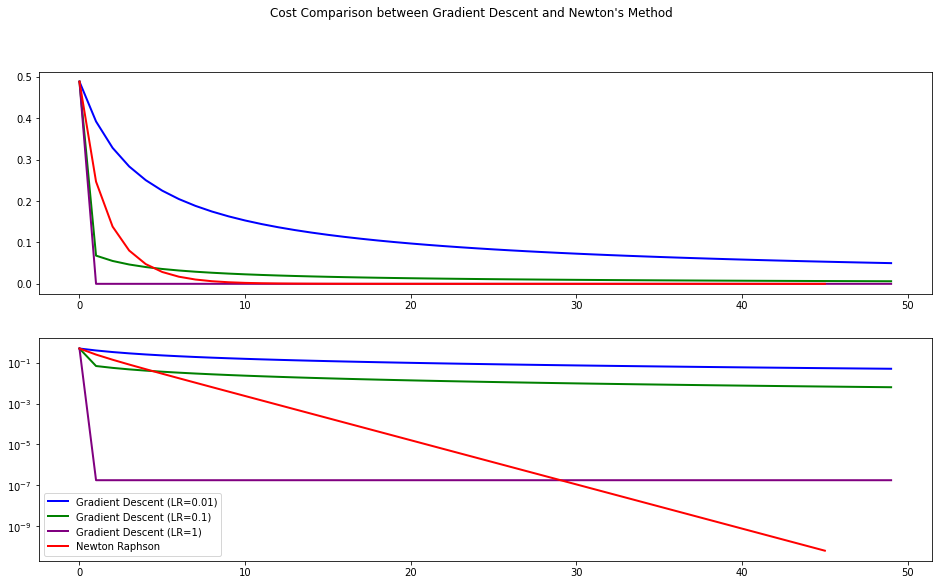

In [17]:
df = pd.DataFrame({'iteration': range(50), 
                   'Gradient Descent (LR=0.01)': gd_01_costs,
                   'Gradient Descent (LR=0.1)': gd_1_costs,
                   'Gradient Descent (LR=1)': gd1_costs,
                   'Newton Raphson': nr_costs})

fig, ax = plt.subplots(2, figsize=[16, 9])
fig.suptitle('Cost Comparison between Gradient Descent and Newton\'s Method')

ax[0].plot('iteration', 'Gradient Descent (LR=0.01)', data=df, marker='', color='blue', linewidth=2)
ax[0].plot('iteration', 'Gradient Descent (LR=0.1)', data=df, marker='', color='green', linewidth=2)
ax[0].plot('iteration', 'Gradient Descent (LR=1)', data=df, marker='', color='purple', linewidth=2)
ax[0].plot('iteration', 'Newton Raphson', data=df, marker='', color='red', linewidth=2)

ax[1].plot('iteration', 'Gradient Descent (LR=0.01)', data=df, marker='', color='blue', linewidth=2)
ax[1].plot('iteration', 'Gradient Descent (LR=0.1)', data=df, marker='', color='green', linewidth=2)
ax[1].plot('iteration', 'Gradient Descent (LR=1)', data=df, marker='', color='purple', linewidth=2)
ax[1].plot('iteration', 'Newton Raphson', data=df, marker='', color='red', linewidth=2)

ax[1].set_yscale('log')
plt.legend()
plt.show()

In [18]:
sc.stop()